<a href="https://colab.research.google.com/github/GiX7000/object-detection/blob/main/RetinaNet_on_PascalVoc_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of RetinaNet on a subset of PascalVoc

Use of [Fizyr's](https://github.com/fizyr/keras-retinanet) official implementation.

In [1]:
# get retinanet and install the appropriate environment

!git clone https://github.com/fizyr/keras-retinanet.git

%cd keras-retinanet/

!pip install .

!python setup.py build_ext --inplace

import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (4201/4201), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168020 sha256=36490f3be97ce098de72d3e8d7fb1b76598727d21f3bb1721638c22ff8d38ea7
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=9aab9cc3ac88850726b510a00230c17291df78537fbb2638a33425b8b4ee76fe
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_

In [2]:
# mount drive to get the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Images_set3b is subset of Pascal Voc dataset, which is comprised of a specific number of specific classes. More details at PascalVoc_Subset.ipynb.

In [3]:
# copy dataset to Colab VM
%cd /content/drive/MyDrive/
!cp -r images_set3b /content/keras-retinanet/images/

/content/drive/MyDrive


In [4]:
# create annotations.csv and classes.csv files
%cd /content/keras-retinanet/images/images_set3b

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

# annotation csvs
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member.find("bndbox").find('xmin').text),
                     int(member.find("bndbox").find('ymin').text),
                     int(member.find("bndbox").find('xmax').text),
                     int(member.find("bndbox").find('ymax').text))
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    datasets = ['train', 'test']
    for ds in datasets:
      image_path = os.path.join(os.getcwd(), ds)
      xml_df = xml_to_csv(image_path)
      xml_df.to_csv(ds + '_annotations.csv', index=None)
print('Successfully converted xml to csv.')

main()

# classes csv
classes = [['cow',0], ['horse',1], ['sheep',2], ['person',3]]

with open('classes.csv', 'w', newline='') as f:
  writer = csv.writer(f)
  #writer.writerow(["class_name", "class_id"])
  writer.writerows(classes)
print('Successfully created classes.csv file')

/content/keras-retinanet/images/images_set3b
Successfully converted xml to csv.
Successfully created classes.csv file


In [5]:
# transform csvs to retinanet csv format. More info about retina's csv format here: https://github.com/fizyr/keras-retinanet

csv_files = ['train_annotations.csv', 'test_annotations.csv']

for csv_file in csv_files:
  f = pd.read_csv(csv_file)
  # keep filename, xmin, ymin, xmax, ymax, class columns
  keep_col = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
  tmp = f[keep_col]
  # skip the header row from top
  tmp.columns = tmp.iloc[0]
  final = tmp[1:]
  final.to_csv('retinanet_'+csv_file, index=False)
  

In [6]:
# keep rows with objects that belong in our classes_list

retinanet_csv_files = ['retinanet_train_annotations.csv', 'retinanet_test_annotations.csv']
classes_list = ['cow', 'horse', 'sheep', 'person']

with open('retinanet_train_annotations.csv', 'r') as inp, open('final_retinanet_train_annotations.csv', 'w') as out:
    writer = csv.writer(out)
    for row in csv.reader(inp):
        if row[5] in classes_list:
            writer.writerow(row)

with open('retinanet_test_annotations.csv', 'r') as inp, open('final_retinanet_test_annotations.csv', 'w') as out:
    writer = csv.writer(out)
    for row in csv.reader(inp):
        if row[5] in classes_list:
            writer.writerow(row)

# move csvs in train/test images dirs
!mv final_retinanet_train_annotations.csv /content/keras-retinanet/images/images_set3b/train
!mv final_retinanet_test_annotations.csv /content/keras-retinanet/images/images_set3b/test

# Training Model


In [7]:
# download the pre-trained model
import urllib.request

PRETRAINED_MODEL = '/content/keras-retinanet/snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)


('/content/keras-retinanet/snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7fbcd6201590>)

In [8]:
# total training time
!pip install ipython-autotime

%load_ext autotime

time: 185 µs (started: 2021-04-25 14:44:45 +00:00)


In [12]:
%cd /content/keras-retinanet/images/images_set3b

/content/keras-retinanet/images/images_set3b
time: 2.5 ms (started: 2021-04-25 14:56:52 +00:00)


In [23]:
# define steps_per_epoch = len(X_train)//batch_size
batch_size = 6
print( len(os.listdir('/content/keras-retinanet/images/images_set3b/train'))/2  // batch_size) # remember that train folder contains images and their corespnding xmls, that's why there's a division with 2

29.0
time: 5.59 ms (started: 2021-04-25 15:01:26 +00:00)


In [24]:
# start training
%cd /content/keras-retinanet/keras_retinanet/bin

!python train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 6 --steps 29 --epochs 5 csv /content/keras-retinanet/images/images_set3b/train/final_retinanet_train_annotations.csv /content/keras-retinanet/images/images_set3b/classes.csv

/content/keras-retinanet/keras_retinanet/bin
2021-04-25 15:02:13.136307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-04-25 15:02:15.206900: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-25 15:02:15.208251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-25 15:02:15.240778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-25 15:02:15.241590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.9

In [36]:
# convert training model to inference model
!python convert_model.py /content/keras-retinanet/keras_retinanet/bin/snapshots/resnet50_csv_05.h5 /content/keras-retinanet/keras_retinanet/bin/snapshots/my_resnet50_csv_05.h5

2021-04-25 15:30:25.039457: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-25 15:30:26.883688: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-25 15:30:26.884805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-25 15:30:26.909832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-25 15:30:26.910640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-04-25 15:30:26.910692: I tensorflow/stream_executor/platform/default/dso_lo

In [37]:
# evaluation
!python evaluate.py --save-path /content/keras-retinanet/keras_retinanet/bin/snapshots csv /content/keras-retinanet/images/images_set3b/test/final_retinanet_test_annotations.csv /content/keras-retinanet/images/images_set3b/classes.csv /content/keras-retinanet/keras_retinanet/bin/snapshots/my_resnet50_csv_05.h5

2021-04-25 15:31:07.598525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Loading model, this may take a second...
2021-04-25 15:31:09.691609: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-25 15:31:09.692467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-25 15:31:09.712955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-25 15:31:09.713809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-04-25 15:31:09.713854: I tensorflo

In [ ]:
# start Tensorboard
# some modifications needed to original python scripts, , as well as to print mAR and f1 score above!

In [40]:
# export the trained model to drive
COLAB_MODEL = '/content/keras-retinanet/keras_retinanet/bin/snapshots/my_resnet50_csv_05.h5'
DRIVE_DIR = '/content/drive/MyDrive/'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

'/content/drive/MyDrive/my_resnet50_csv_05.h5'

time: 786 ms (started: 2021-04-25 15:44:22 +00:00)


In [66]:
# test the model
THRES_SCORE = 0.6

# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
tf.config.list_physical_devices('GPU') 
#keras.backend.tensorflow_backend.set_session(get_session())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

time: 413 ms (started: 2021-04-25 16:08:48 +00:00)


In [71]:
# load the model from last checkpoint
model_path = '/content/keras-retinanet/keras_retinanet/bin/snapshots/resnet50_csv_05.h5'
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv('/content/keras-retinanet/images/images_set3b/classes.csv',header=None).T.loc[0].to_dict()

/content/keras-retinanet/keras_retinanet/bin/snapshots/resnet50_csv_05.h5
time: 3.23 s (started: 2021-04-25 16:13:39 +00:00)


In [80]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      print(caption)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(20, 20))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

time: 394 ms (started: 2021-04-25 16:16:49 +00:00)


Saving 105530161_305217053945038_2454820986676445727_n.png to 105530161_305217053945038_2454820986676445727_n (4).png
Running inference on: 105530161_305217053945038_2454820986676445727_n.png
processing time:  0.4242677688598633
person 0.865
person 0.608


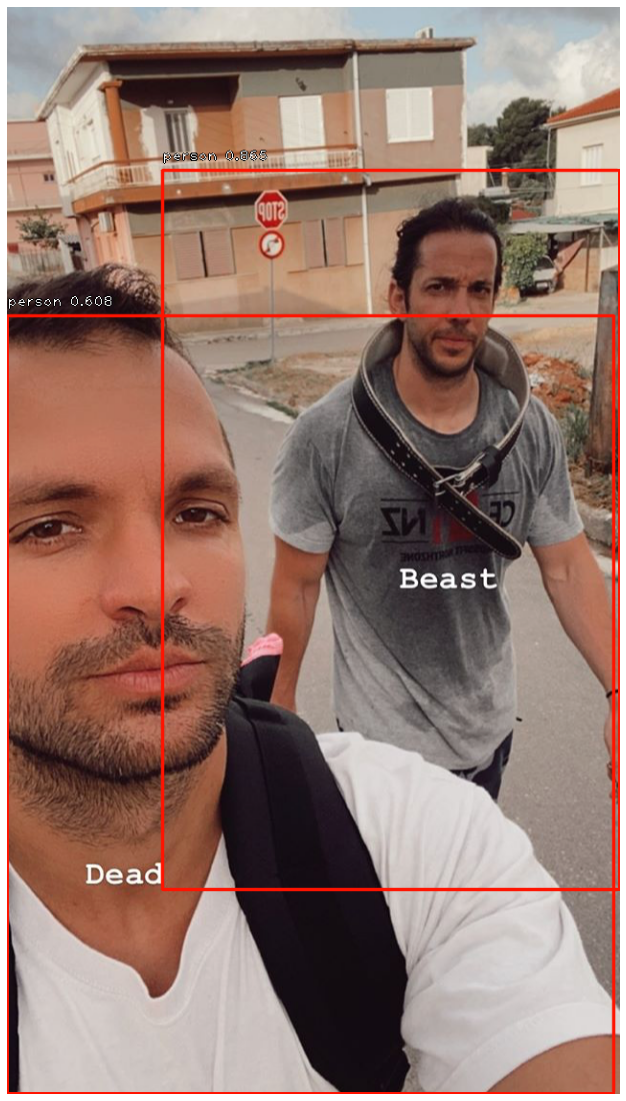

time: 19.4 s (started: 2021-04-25 16:16:49 +00:00)


In [81]:
# upload an image for testing
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)